In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rolaehab","key":"e3f0c800732eaf3f288b7f1bd0b80aeb"}'}

In [2]:
!pip install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions list

ref                                                                              deadline             category                reward  teamCount  userHasEntered  
-------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/arc-prize-2025                               2025-11-03 23:59:00  Featured         1,000,000 Usd        993           False  
https://www.kaggle.com/competitions/jigsaw-agile-community-rules                 2025-10-24 06:59:00  Featured           100,000 Usd       1451           False  
https://www.kaggle.com/competitions/mitsui-commodity-prediction-challenge        2025-10-06 23:59:00  Featured           100,000 Usd       1114           False  
https://www.kaggle.com/competitions/google-code-golf-2025                        2025-10-30 23:59:00  Research           100,000 Usd        651           False  
https://www.kaggle.com/compe

In [5]:
!kaggle competitions download -c playground-series-s5e8

playground-series-s5e8.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip playground-series-s5e8.zip

Archive:  playground-series-s5e8.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [7]:
!pip install category_encoders

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import category_encoders as ce
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder, RobustScaler, StandardScaler,LabelEncoder

from sklearn.impute import KNNImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")


In [10]:
train

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,749995,29,services,single,secondary,no,1282,no,yes,unknown,4,jul,1006,2,-1,0,unknown,1
749996,749996,69,retired,divorced,tertiary,no,631,no,no,cellular,19,aug,87,1,-1,0,unknown,0
749997,749997,50,blue-collar,married,secondary,no,217,yes,no,cellular,17,apr,113,1,-1,0,unknown,0
749998,749998,32,technician,married,secondary,no,-274,no,no,cellular,26,aug,108,6,-1,0,unknown,0


# EDA

In [11]:
train.duplicated().sum()

np.int64(0)

In [12]:
test.duplicated().sum()

np.int64(0)

In [13]:
train.info() # drop id, no nulls(explore for uniques in cat, day & month (dates), )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


## Categorical

In [14]:
cat_f = train.select_dtypes('O').columns.to_list()
cat_f

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [15]:
num_f = train.select_dtypes(exclude='O').columns.to_list()
num_f

['id',
 'age',
 'balance',
 'day',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'y']

In [16]:
for col in cat_f:
  print(f"{col} unique values : {train[col].unique()}\n")
  #unknown values in['job', 'education', 'contact','poutcome']
  #other values in poutcome

job unique values : ['technician' 'blue-collar' 'student' 'admin.' 'management' 'entrepreneur'
 'self-employed' 'unknown' 'services' 'retired' 'housemaid' 'unemployed']

marital unique values : ['married' 'single' 'divorced']

education unique values : ['secondary' 'primary' 'tertiary' 'unknown']

default unique values : ['no' 'yes']

housing unique values : ['no' 'yes']

loan unique values : ['no' 'yes']

contact unique values : ['cellular' 'unknown' 'telephone']

month unique values : ['aug' 'jun' 'may' 'feb' 'apr' 'nov' 'jul' 'jan' 'oct' 'mar' 'sep' 'dec']

poutcome unique values : ['unknown' 'other' 'failure' 'success']



In [17]:
missing = ['job', 'education', 'contact','poutcome']

In [18]:
for col in missing:
  print(f"{col} precentage of missing : {train[col].value_counts()['unknown']/train[col].value_counts().sum()*100} %\n")
  # fill job, education with mode
  # contact imputation
  # drop poutcome

job precentage of missing : 0.3889333333333333 %

education precentage of missing : 2.8398666666666665 %

contact precentage of missing : 30.8836 %

poutcome precentage of missing : 89.66 %



In [19]:
train['poutcome'].value_counts()

,count
poutcome,
unknown,672450
failure,45115
success,17691
other,14744


In [20]:
# plt.figure(figsize=(18, 18))
# for i, col in enumerate(cat_f):
#     plt.subplot(3, 3, i+1)
#     order = train[col].value_counts().index
#     sns.countplot(data=train, x=col, order = order)
#     plt.title(f"{col} Distribution")
#     plt.xticks(rotation=45)

# plt.suptitle("Countplots for Categorical features", fontsize=25, weight="bold")
# plt.tight_layout(rect=[0, 0, 1, 0.95])
# # default and contact has near to no variance so if it has a strong relation with target i will keep if not i will drop

In [21]:
x = ['default', 'poutcome', 'contact', 'loan']

In [22]:
# plt.figure(figsize=(10, 10))
# for i, col in enumerate(x):
#     plt.subplot(2, 2, i+1)
#     sns.countplot(data=train, x=col, hue='y')
#     plt.title(f"{col} VS Target")
#     plt.xticks(rotation=45)
# plt.tight_layout(rect=[0, 0, 1, 0.95])

- Drop poutcome(90% unknown), default(no variablity most of the data => no), id
- Mode imputation job, education
- Imputation (knn, iterative,....) for contact

## Numerical

In [23]:
num_f = num_f[1:]

In [24]:
train[num_f].describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


In [25]:
# plt.figure(figsize=(25, 25))
# for i, col in enumerate(num_f):
#   plt.subplot(3,3, i+1)
#   train[col].hist(bins = 30)
#   plt.title(f"{col} Distribution")
# plt.suptitle("Numerical Variables Distributions", fontsize=26, weight="bold")
# plt.tight_layout(rect=[0, 0, 1, 0.95])

In [26]:
# plt.figure(figsize=(25, 25))
# for i, col in enumerate(num_f):
#   plt.subplot(3,3, i+1)
#   sns.boxplot(data=train, x =col)
#   plt.title(f"{col} Distribution")
# plt.suptitle("Numerical Variables Boxplots", fontsize=26, weight="bold")
# plt.tight_layout(rect=[0, 0, 1, 0.95])

- Close to Normal Distributions (age, day)
- Weird points (previous(200), pdays(-1))
- Balance (there are lots of negative values)

In [27]:
train[train['previous'] ==200]

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
537358,537358,27,technician,single,tertiary,no,0,no,no,cellular,17,sep,7,1,100,200,other,0


In [28]:
test[test['previous'] ==200]

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome


In [29]:
train[train['pdays'] == -1 ].shape[0]/train.shape[0]*100

89.65786666666666

In [30]:
test[test['pdays'] == -1 ].shape[0]/train.shape[0]*100

29.881600000000002

In [31]:
train[train['pdays'] == -1 ].shape[0]/train.shape[0]*100

89.65786666666666

In [32]:
train[train['balance'] <= 0 ].shape[0]/train.shape[0]*100

26.373866666666668

- drop pdays since there is no variation

In [33]:
# sns.heatmap(train[num_f].corr(), annot=True)

In [34]:
# sns.pairplot(data = train[num_f], hue='y')

# Preprocessing

In [44]:
cat_f

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

Steps


1.   Drop poutcome(90% unknown), default(no variablity most of the data => no), id, pdays(no variabity 90% => -1) DONE
2.   Mode imputation job, education DONE
3.   **Imputation (knn, iterative,....) for contact** I decided to continue with missing as a category and went with XGBoost
4.   Drop previous(200) row DONE
5.   **Close to Normal Distributions (age, day)**
6.   **Balance, duration, campaign has many outliers**
7.   **Ordinal data [education, month], nominal['job',
 'marital','default',
 'housing',
 'loan',
 'contact']**
8. **Unbalanced data** used class weight


In [45]:
todrop = ['poutcome', 'default', 'id', 'pdays'] #
modeimp = ['job', 'education']#
imp = ['contact']#
normal = ['age', 'day']
outliers = ['balance', 'duration', 'campaign']
ordinal_f = ['education', 'month']#
nominal_f = ['job', 'marital', 'housing', 'loan', 'contact']#

In [46]:
train.drop(train[train['previous'] == 200].index, inplace=True)

In [47]:
train[train['previous'] ==200]

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y


In [48]:
train.drop(columns=todrop, inplace=True)
test.drop(columns=todrop, inplace=True)

In [49]:
train.columns

Index(['age', 'job', 'marital', 'education', 'balance', 'housing', 'loan',
       'contact', 'day', 'month', 'duration', 'campaign', 'previous', 'y'],
      dtype='object')

In [50]:
mode_job = train['job'].mode()[0]
mode_edu = train['education'].mode()[0]

In [51]:
train['job'] = train['job'].replace({'unknown': mode_job})
test['job'] = test['job'].replace({'unknown': mode_job})

In [52]:
train['job'].unique()

array(['technician', 'blue-collar', 'student', 'admin.', 'management',
       'entrepreneur', 'self-employed', 'services', 'retired',
       'housemaid', 'unemployed'], dtype=object)

In [53]:
for col in ordinal_f:
  print(f"{col} nunique : {train[col].nunique()}\n")

education nunique : 4

month nunique : 12



In [54]:
ptrain = train.copy()
ptest = test.copy()
ytrain = ptrain['y']
ptrain.drop(columns ='y', inplace=True)

In [55]:
num_f = ptrain.select_dtypes(exclude='O').columns.to_list()
num_f

['age', 'balance', 'day', 'duration', 'campaign', 'previous']

In [56]:
cat_f=ptrain.select_dtypes(include='O').columns.to_list()
cat_f

['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month']

In [57]:
ptrain

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,previous
0,42,technician,married,secondary,7,no,no,cellular,25,aug,117,3,0
1,38,blue-collar,married,secondary,514,no,no,unknown,18,jun,185,1,0
2,36,blue-collar,married,secondary,602,yes,no,unknown,14,may,111,2,0
3,27,student,single,secondary,34,yes,no,unknown,28,may,10,2,0
4,26,technician,married,secondary,889,yes,no,cellular,3,feb,902,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,29,services,single,secondary,1282,no,yes,unknown,4,jul,1006,2,0
749996,69,retired,divorced,tertiary,631,no,no,cellular,19,aug,87,1,0
749997,50,blue-collar,married,secondary,217,yes,no,cellular,17,apr,113,1,0
749998,32,technician,married,secondary,-274,no,no,cellular,26,aug,108,6,0


In [58]:
ptest.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,previous
0,32,blue-collar,married,secondary,1397,yes,no,unknown,21,may,224,1,0
1,44,management,married,tertiary,23,yes,no,cellular,3,apr,586,2,0
2,36,self-employed,married,primary,46,yes,yes,cellular,13,may,111,2,0
3,58,blue-collar,married,secondary,-1380,yes,yes,unknown,29,may,125,1,0
4,28,technician,single,secondary,1950,yes,no,cellular,22,jul,181,1,0


# Categorical Encoding


*   Ordinal (oe)
*   Nominal (ohe + Label)



In [59]:
ordinal_f

['education', 'month']

In [60]:
oe = OrdinalEncoder()

In [61]:
ptrain[ordinal_f] = oe.fit_transform(ptrain[ordinal_f])
ptest[ordinal_f] = oe.transform(ptest[ordinal_f])

In [62]:
ptrain.head(2)

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,previous
0,42,technician,married,1.0,7,no,no,cellular,25,1.0,117,3,0
1,38,blue-collar,married,1.0,514,no,no,unknown,18,6.0,185,1,0


In [63]:
nominal_f

['job', 'marital', 'housing', 'loan', 'contact']

In [64]:
for col in nominal_f:
  print(f"{col} nunique : {ptrain[col].nunique()}\n")

job nunique : 11

marital nunique : 3

housing nunique : 2

loan nunique : 2

contact nunique : 3



- marital => one hot encoder (remove first)
- housing and loan and contact cant be used with one hot because when removing one feature it will be binary
- So the rest will use target encoder

In [65]:
ohe_f = ['marital','housing', 'loan', 'job', 'contact']
te_f =['job', 'contact']

In [66]:
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

In [67]:
ptrain['contact'] = ptrain['contact'].replace({'unknown': np.nan})
ptest['contact'] = ptest['contact'].replace({'unknown': np.nan})

In [68]:
X_train_ohe = ohe.fit_transform(ptrain[ohe_f])
X_test_ohe = ohe.transform(ptest[ohe_f])

In [69]:
X_train_ohe_df = pd.DataFrame(
    X_train_ohe,
    columns=ohe.get_feature_names_out(ohe_f),
    index=ptrain.index
)

X_test_ohe_df = pd.DataFrame(
    X_test_ohe,
    columns=ohe.get_feature_names_out(ohe_f),
    index=ptest.index
)

In [70]:
ptrain = pd.concat([ptrain, X_train_ohe_df], axis = 1)
ptest= pd.concat([ptest, X_test_ohe_df], axis = 1)

In [71]:
ptrain.drop(columns=ohe_f, inplace=True)

In [72]:
ptest.drop(columns=ohe_f, inplace=True)

In [73]:
ptrain.head(2)

,age,education,balance,day,month,duration,campaign,previous,marital_married,marital_single,...,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,contact_telephone,contact_nan
0,42,1.0,7,25,1.0,117,3,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,38,1.0,514,18,6.0,185,1,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [74]:
ptrain.shape

(749999, 24)

Next
- Numeric Scaling
- Missing Imputation

## Scaling

In [75]:
normal

['age', 'day']

In [76]:
outliers

['balance', 'duration', 'campaign']

In [77]:
normal + outliers

['age', 'day', 'balance', 'duration', 'campaign']

In [78]:
rs = RobustScaler()
ss = StandardScaler()

In [79]:
ssdftrain = ss.fit_transform(ptrain[normal])
ssdftest = ss.transform(ptest[normal])

In [80]:
rsdftrain = rs.fit_transform(ptrain[outliers])
rsdftest  = rs.transform(ptest[outliers])

In [81]:
trainscal = pd.DataFrame(np.concatenate([ssdftrain, rsdftrain], axis=1)
                        , columns=normal + outliers
                        ,index= ptrain.index)

testscal = pd.DataFrame(np.concatenate([ssdftest, rsdftest], axis = 1)
                        , columns=normal + outliers
                        ,index = ptest.index)

In [82]:
trainscal.head(2)

,age,day,balance,duration,campaign
0,0.106308,1.076593,-0.451079,-0.059259,0.5
1,-0.289778,0.228194,-0.086331,0.192593,-0.5


In [83]:
ptrain.drop(columns= num_f, inplace=True)
ptest.drop(columns= num_f, inplace=True)

In [84]:
ptrain= pd.concat([trainscal, ptrain], axis = 1)
ptest = pd.concat([testscal, ptest], axis = 1)

In [85]:
ptrain.head(2)

,age,day,balance,duration,campaign,education,month,marital_married,marital_single,housing_yes,...,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,contact_telephone,contact_nan
0,0.106308,1.076593,-0.451079,-0.059259,0.5,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,-0.289778,0.228194,-0.086331,0.192593,-0.5,1.0,6.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Modeling

In [86]:
ytrain.head(1)

,y
0,0


In [87]:
ytrain.value_counts()

,count
y,
0,659511
1,90488


## Balancing Data

In [88]:
print(ytrain.value_counts(normalize=True))

y
0    0.879349
1    0.120651
Name: proportion, dtype: float64


In [89]:
neg, pos = (ytrain == 0).sum(), (ytrain == 1).sum()
scale_pos_weight = neg / pos
print(f"scale_pos_weight: {scale_pos_weight:.2f}")

scale_pos_weight: 7.29


In [90]:
# from imblearn.over_sampling import SMOTE

# sm = SMOTE(random_state=42)
# X_resampled, y_resampled = sm.fit_resample(ptrain, ytrain)

# print(y_resampled.value_counts())

# Models

In [91]:
def evaluate_model(model, X_train, ytrain, model_name, plot_importance=False):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:, 1]

    train_auc = roc_auc_score(ytrain, y_train_proba)

    print(f"\n{model_name}")
    print(f"Train ROC-AUC: {train_auc:.4f}")

    print("\n--- Train Set ---")
    print("Classification Report:\n", classification_report(ytrain, y_train_pred))
    print("Confusion Matrix:\n", confusion_matrix(ytrain, y_train_pred))

    fpr, tpr, _ = roc_curve(ytrain, y_train_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {train_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()

## Random Forest

In [101]:
rf = RandomForestClassifier( n_jobs=-1,
                              random_state=42,
                              max_depth=30,
                              min_samples_leaf=20,
                              max_features="sqrt",
                              class_weight="balanced")

In [102]:
rf.fit(ptrain, ytrain)

RandomForestClassifier(class_weight='balanced', max_depth=30,
                       min_samples_leaf=20, n_jobs=-1, random_state=42)


Random Forest
Train ROC-AUC: 0.9656

--- Train Set ---
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.92    659511
           1       0.49      0.95      0.65     90488

    accuracy                           0.88    749999
   macro avg       0.74      0.91      0.79    749999
weighted avg       0.93      0.88      0.89    749999

Confusion Matrix:
 [[571218  88293]
 [  4784  85704]]


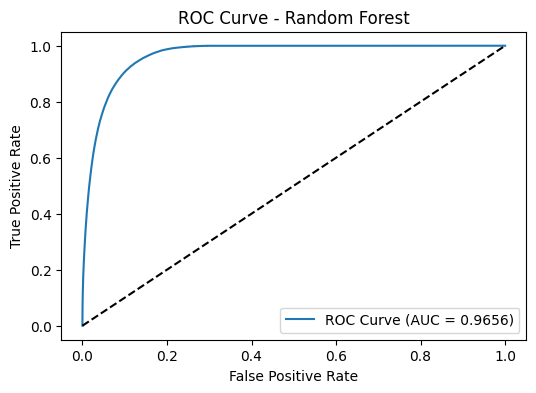

In [103]:
evaluate_model(rf,ptrain, ytrain, "Random Forest")

## Logistic Regression

In [104]:
lr = LogisticRegression(random_state=42,class_weight="balanced")

In [105]:
lr.fit(ptrain, ytrain)

LogisticRegression(class_weight='balanced', random_state=42)


Logistic Regression
Train ROC-AUC: 0.9210

--- Train Set ---
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.86      0.91    659511
           1       0.45      0.84      0.59     90488

    accuracy                           0.86    749999
   macro avg       0.71      0.85      0.75    749999
weighted avg       0.91      0.86      0.87    749999

Confusion Matrix:
 [[565941  93570]
 [ 14216  76272]]


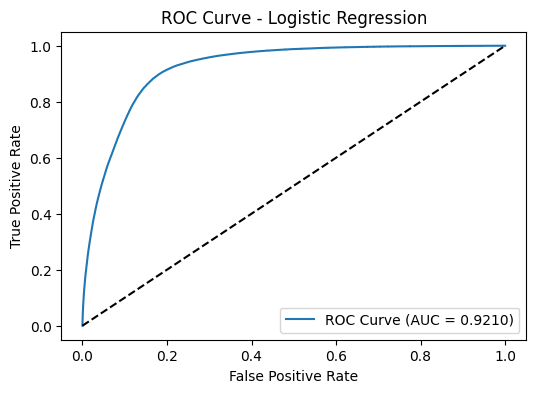

In [106]:
evaluate_model(lr, ptrain, ytrain, "Logistic Regression")

## XGBoost

In [107]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    colsample_bytree=0.6,
    gamma=0.3,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=300,
    subsample=1.0,
    n_jobs=-1,

)
model.fit(ptrain, ytrain)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=-1,
              num_parallel_tree=None, ...)


XGBoost
Train ROC-AUC: 0.9531

--- Train Set ---
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96    659511
           1       0.73      0.57      0.64     90488

    accuracy                           0.92    749999
   macro avg       0.84      0.77      0.80    749999
weighted avg       0.92      0.92      0.92    749999

Confusion Matrix:
 [[640680  18831]
 [ 38580  51908]]


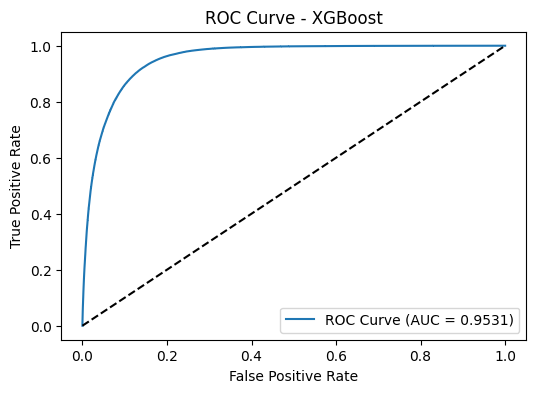

In [108]:
evaluate_model(model, ptrain, ytrain, "XGBoost")

# Stacking

In [92]:
base_learners = [
    ("xgb", XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    colsample_bytree=0.6,
    gamma=0.3,
    learning_rate=0.05,
    max_depth=3,
    n_estimators=300,
    subsample=1.0,
    n_jobs=-1,

)),
    ("rf", RandomForestClassifier( n_jobs=-1,
                              random_state=42,
                              max_depth=30,
                              min_samples_leaf=20,
                              max_features="sqrt",
                              class_weight="balanced")),
]

In [93]:
meta_model = LogisticRegression(random_state=42,class_weight="balanced")

In [94]:
sm = StackingClassifier(
    estimators = base_learners,
    final_estimator = meta_model,
    cv = 5,
    n_jobs = -1, passthrough = False
)

In [95]:
sm.fit(ptrain, ytrain)

StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.6, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=0.3,
                                              grow_policy=None,
                                              importance_type=None,
                                              interacti...
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=300, n_jobs=-1,
                                              num_parallel_tree=None, ...)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=30,
                                                       min_samples_leaf=20,
                                                       n_jobs=-1,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(class_weight='balanced',
                                                      random_state=42),
                   n_jobs=-1)


Stacking best Alg
Train ROC-AUC: 0.9649

--- Train Set ---
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.87      0.93    659511
           1       0.50      0.94      0.66     90488

    accuracy                           0.88    749999
   macro avg       0.75      0.91      0.79    749999
weighted avg       0.93      0.88      0.90    749999

Confusion Matrix:
 [[575647  83864]
 [  5495  84993]]


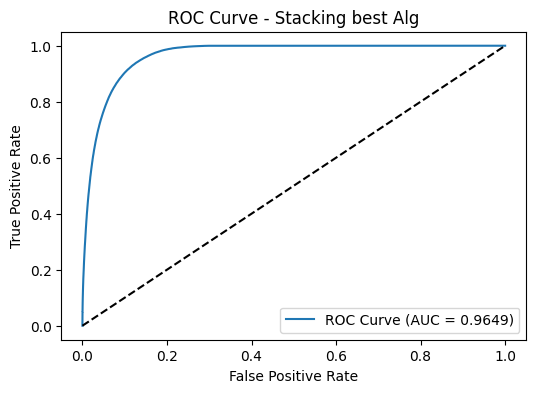

In [96]:
evaluate_model(sm, ptrain, ytrain, "Stacking best Alg")

In [120]:
def plot_auc_bar(models, X_test, y_test):
    model_names = []
    auc_scores = []

    for model_name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_prob)
        model_names.append(model_name)
        auc_scores.append(auc_score)

    # bar chart
    colors = plt.cm.Set2(range(len(models)))
    plt.figure(figsize=(8, 6))
    bars = plt.bar(model_names, auc_scores, color=colors)
    plt.ylabel("AUC Score")
    plt.title("Model Comparison - AUC Scores")
    plt.ylim(0, 1)

    # score labels
    for bar, score in zip(bars, auc_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f"{score:.3f}", ha='center', va='bottom', fontsize=10)

    plt.show()

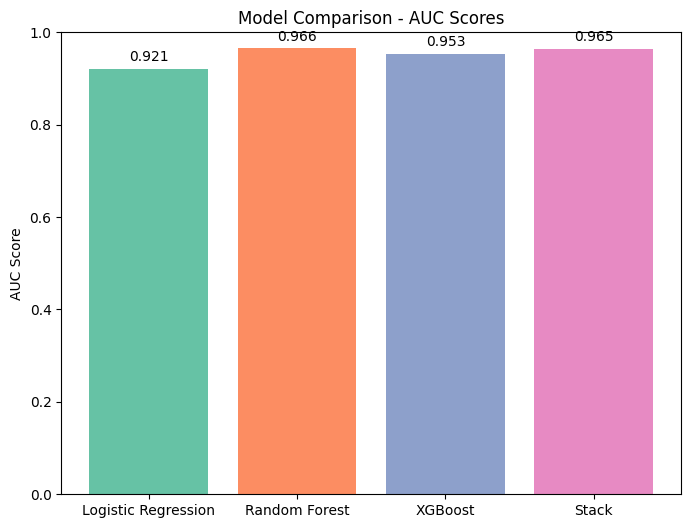

In [121]:
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "XGBoost": model,
    "Stack": sm
}

plot_auc_bar(models, ptrain, ytrain)

# Submition

In [122]:
ypred = sm.predict_proba(ptest)
sample_submission["y"] = ypred[:,1]

In [123]:
sample_submission.to_csv("submission.csv", index=False)

In [124]:
 !kaggle competitions submit -c playground-series-s5e8 -f submission.csv -m "Final submission"

100% 6.44M/6.44M [00:00<00:00, 13.4MB/s]
Successfully submitted to Binary Classification with a Bank Dataset